In [1]:
import geopandas as gpd
import warnings
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import accuracy_score
from shapely.errors import ShapelyDeprecationWarning

from helper import root

warnings.filterwarnings(action="ignore", category=ShapelyDeprecationWarning)


2021-12-17 03:49:25.904076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nfshomes/izvonkov/torch/install/lib:
2021-12-17 03:49:25.904117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
competition = "ref_fusion_competition_south_africa"
labels_258_path = root / f"{competition}_train_labels/{competition}_train_labels_34S_19E_258N/labels.geojson"
labels_258 = gpd.read_file(labels_258_path)

labels_259_path = root / f"{competition}_train_labels/{competition}_train_labels_34S_19E_259N/labels.geojson"
labels_259 = gpd.read_file(labels_259_path)

labels = pd.concat([labels_258, labels_259], ignore_index=True)

labels_test_path = root / f"{competition}_test_labels/{competition}_test_labels_34S_20E_259N/labels.geojson"
labels_test = gpd.read_file(labels_test_path)

In [8]:
def get_y_pred(model_id: str = "btt8xazt-epoch31"):
    p = root.parent / f"submissions/{model_id}/34S-20E-259N-2017-submission-{model_id}.json"
    with p.open("r") as f:
        submission = json.load(f)

    return np.array(list(submission["crop_id"].values()))

In [14]:
model_id = "btt8xazt-epoch31"
p = root.parent / f"submissions/{model_id}/34S-20E-259N-2017-submission-{model_id}.json"
with p.open("r") as f:
    submission = json.load(f)

In [20]:
df = pd.DataFrame(submission)

In [29]:
df["crop_id"].value_counts()

4    1698
1     413
5     199
2      59
3      48
Name: crop_id, dtype: int64

In [36]:
df.iloc[3]

fid                                                      185495
crop_id                                                       4
crop_name                                        Lucerne/Medics
crop_probs    [0.0123134553, 0.0252904259, 0.0020230536, 0.9...
Name: 3, dtype: object

In [38]:
df.iloc[3]["crop_probs"]

[0.0123134553, 0.0252904259, 0.0020230536, 0.9485732317, 0.0117998486]

In [31]:
df["crop_name"].value_counts()

Lucerne/Medics         1698
Wheat                   413
Small grain grazing     199
Barley                   59
Canola                   48
Name: crop_name, dtype: int64

In [9]:
best_models = [
    ("btt8xazt-epoch31", 5.108),
    ("2oi3ijbb-epoch23", 5.35),
    ("1k59ieij-epoch41", 5.49),
    ("ahqialkz-epoch13", 5.51),
    ("3gfvferq-68", 5.84)
]

best_models = [(model_id, score, get_y_pred(model_id)) for model_id, score in best_models]


<AxesSubplot:>

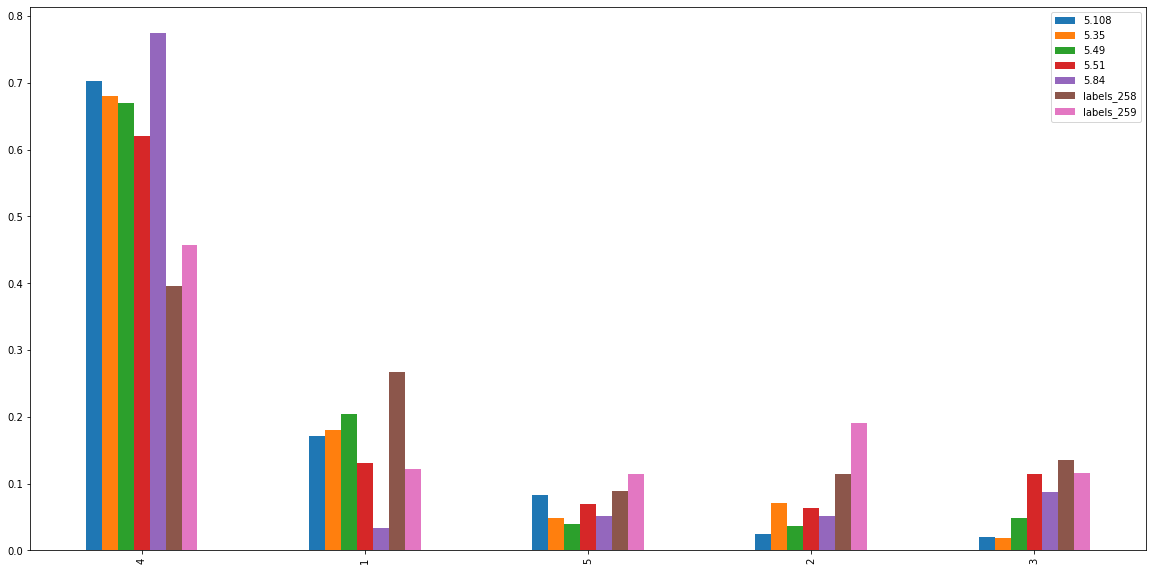

In [147]:
distributions = pd.DataFrame({})
for model_id, score, y_pred in best_models:
    distributions[score] = pd.Series(y_pred).value_counts(normalize=True)
distributions["labels_258"] = labels_258["crop_id"].value_counts(normalize=True)
distributions["labels_259"] = labels_259["crop_id"].value_counts(normalize=True)
distributions.plot(kind="bar", figsize=(20, 10))

In [132]:
distributions

,y_pred,y_train1
4,0.702524,0.395335
1,0.170873,0.266472
5,0.082333,0.089213
2,0.024410,0.114286
3,0.019859,0.134694


In [148]:
classes = labels_258["crop_id"].unique()
classes.sort()
classes

array([1, 2, 3, 4, 5])

In [149]:
counts = labels_258["crop_id"].value_counts(normalize=True)
probabilities = [counts[c] for c in classes]

In [150]:
cross_entropy_func = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
def scores(y_true, y_pred):
    y_true_ohe = tf.one_hot(y_true - 1, depth=len(classes))
    y_pred_ohe = tf.one_hot(y_pred - 1, depth=len(classes))
    cross_entropy_loss = cross_entropy_func(y_true_ohe, y_pred_ohe).numpy()
    accuracy = accuracy_score(y_true, y_pred)
    return cross_entropy_loss, accuracy

In [152]:
#accuracies = []
losses = []
percent_right = []
y_true = best_models[0][2]
for i in np.arange(0.0, 1.0, 0.1):
    split = round(len(y_true)*i)
    y_pred = np.random.choice(classes, p=probabilities, size=len(y_true))
    y_pred[:split] = y_true[:split]
    loss, accuracy = scores(y_true, y_pred)
    percent_right.append(i)
    losses.append(loss)

In [153]:
# Random guess
y_pred = np.random.choice(classes, size=len(y_true))
scores(y_true, y_pred)

(12.890458, 0.20024824162184526)

In [154]:
# Guessing most common class for everything
# Try this baseline
y_pred = np.array([4]*len(y_true))
scores(y_true, y_pred)

(4.7947516, 0.7025237898220935)

In [159]:
# 50 percent of the time, guess the correct class
split = round(len(y_true)*0.5)
y_pred = np.random.choice(classes, size=len(y_true))
y_pred[:split] = y_true[:split]
scores(y_true, y_pred)

(6.335208, 0.6069507654116674)

In [162]:
# 55 percent of the time, guess the correct class
split = round(len(y_true)*0.55)
y_pred = np.random.choice(classes, size=len(y_true))
y_pred[:split] = y_true[:split]
scores(y_true, y_pred)

(5.8617344, 0.6363260239966901)

In [163]:
# 60 percent of the time, guess the correct class
split = round(len(y_true)*0.6)
y_pred = np.random.choice(classes, size=len(y_true))
y_pred[:split] = y_true[:split]
scores(y_true, y_pred)

(5.2215447, 0.6760446834919321)